In [1]:
from numpy import fromfunction
from PIL import Image, ImageColor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
nx = 1050
ny = 450
#cx,cy,r = nx//4,ny//2,ny/9  # Cylinder coordinates and radius (as integers)
naca0012 = pd.read_csv('airfoil.csv')
naca0012_x = naca0012.iloc[:,0]
naca0012_y = naca0012.iloc[:,1]

rng = np.random.default_rng()
#------------------------------------------------------------------------------
v_lattice = np.array([ 
                      [1,1],
                      [1,0],
                      [1,-1],
                      [0,1],
                      [0,0],
                      [0,-1],
                      [-1,1],
                      [-1,0],
                      [-1,-1]
                             ])

In [4]:
# coords is a tuple containing (x_coords, y_coords)
def rotate_object(ang, coords):
    n = len(coords[0])
    x_coords = np.zeros(n)
    y_coords = np.zeros(n)
    
    for i in range(n):
        coord_rot = rot(ang, [coords[0][i], coords[1][i]])
        x_coords[i] = coord_rot[0]
        y_coords[i] = coord_rot[1]

    return x_coords, y_coords


def rot(ang, v):
    rot_mat = np.array([[np.cos(ang), np.sin(ang)],
                        [-np.sin(ang), np.cos(ang)]])

    return np.matmul(rot_mat, v)

def obs_mask(ang, nx=nx, ny=ny):
    # Draw foil at angle of attack 'ang'
    foil_x, foil_y = rotate_object(ang)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.fill(foil_x, foil_y, 'black')
    ax.set_aspect('equal')
    ax.set_xlim([-3,10])
    ax.set_ylim([-1.5,1.5])
    ax.set_axis_off()

    fig.set_size_inches(nx/300, ny/300)
    plt.savefig('airFoil.jpg', dpi=300)
    plt.close()

    # generate mask
    image = Image.open('airFoil.jpg')
    mask = np.zeros((nx,ny), dtype=bool)
    tol = 150
    
    for i in range(225,400):
        for j in range(175,275):
            if image.getpixel((i,j))[1] <= tol:
                mask[i,j] = True

    return mask

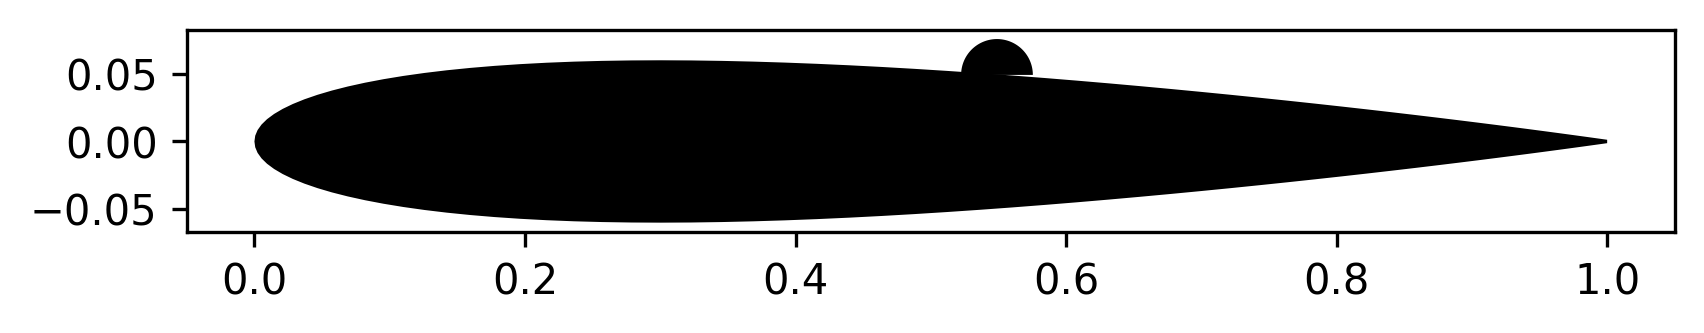

In [57]:
foil_x, foil_y = rotate_object(0, [naca0012_x, naca0012_y])
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.fill(foil_x, foil_y, 'black')
ax.fill(r_t*np.cos(ang_t) + cx_t, r_t*np.sin(ang_t) + cy_t - (r_t*off_t), 'black')
ax.set_aspect('equal')

plt.show()

In [5]:
def naca_y(x, p=0.12):
    return 5*p*(0.2969*np.sqrt(x) - 0.1260*x -0.3516*x**2 + 0.2843*x**3 - 0.1015*x**4)

<Figure size 1920x1440 with 0 Axes>

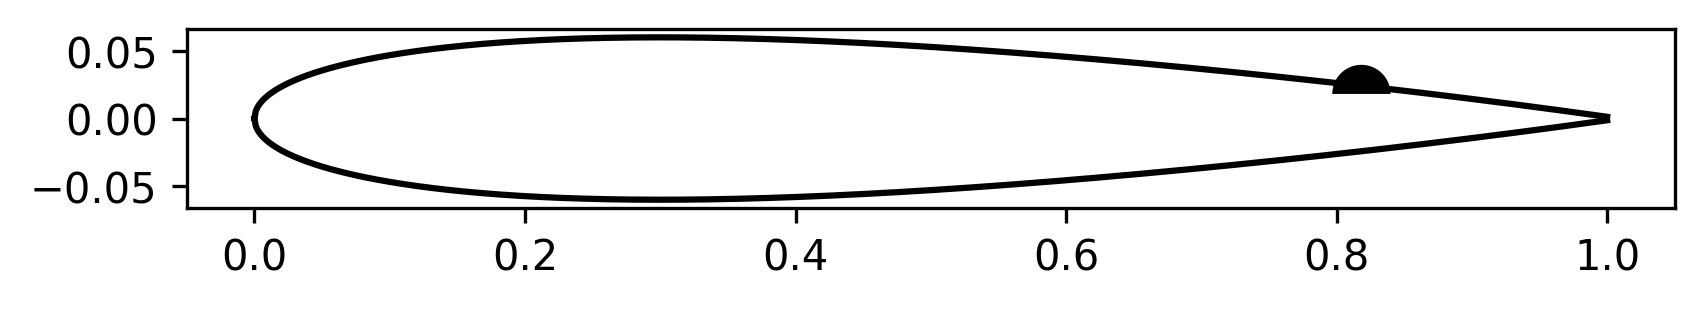

In [6]:
r_test = np.linspace(0,1,1000)
ang_t = np.linspace(0,np.pi,100)
cx_t = rng.uniform(low=0.5, high=0.85)
cy_t = naca_y(cx_t)
r_t = rng.uniform(low=0.02, high=0.04)
off_t = rng.uniform(high=0.5)

plt.clf()
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(r_test, naca_y(r_test), 'black')
ax.plot(r_test, -naca_y(r_test), 'black')
ax.fill(r_t*np.cos(ang_t) + cx_t, r_t*np.sin(ang_t) + cy_t - (r_t*off_t), 'black')
ax.set_aspect('equal')
#ax.set_xlim([-3,10])
#ax.set_ylim([-1.5,1.5])

plt.show()

In [11]:
# Takes in a 3D vector that specifies the location and size
# of the bulge. p[0] is the center's x coordinate, p[1] is the 
# radius and p[2] is the center's y coordinate offset with respect
# to p[0]'s corresponding point on the airfoil.

# Default angle of attack is 28deg
def get_profile_mask(params, rot_ang=np.pi*(24/180), circ_ang=np.linspace(0,np.pi,400), nx=nx, ny=ny, tol=150):
    # Bulge (semicircle) parameters
    cx = params[0]
    cy = naca_y(cx)
    r = params[1]
    y_off = params[2]
    # semicircle x, y coordinates
    circ_x = r*np.cos(circ_ang) + cx
    circ_y = r*np.sin(circ_ang) + cy - (r*y_off)

    # Get rotated coordinates for the foil and bulge
    foil_x, foil_y = rotate_object(rot_ang, coords=[naca0012_x, naca0012_y])
    circ_x, circ_y = rotate_object(rot_ang, coords=[circ_x, circ_y])

    # Plot and save figure
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.fill(foil_x, foil_y, 'black')
    ax.fill(circ_x, circ_y, 'black')
    ax.set_aspect('equal')
    ax.set_xlim([-3,10])
    ax.set_ylim([-1.5,1.5])
    ax.set_axis_off()

    fig.set_size_inches(nx/300, ny/300)
    plt.savefig('airFoil.jpg', dpi=300)
    plt.close()

    # Generate mask
    image = Image.open('airFoil.jpg')
    mask = np.zeros((nx,ny), dtype=bool)
    
    for i in range(225,400):
        for j in range(175,275):
            if image.getpixel((i,j))[1] <= tol:
                mask[i,j] = True

    return mask

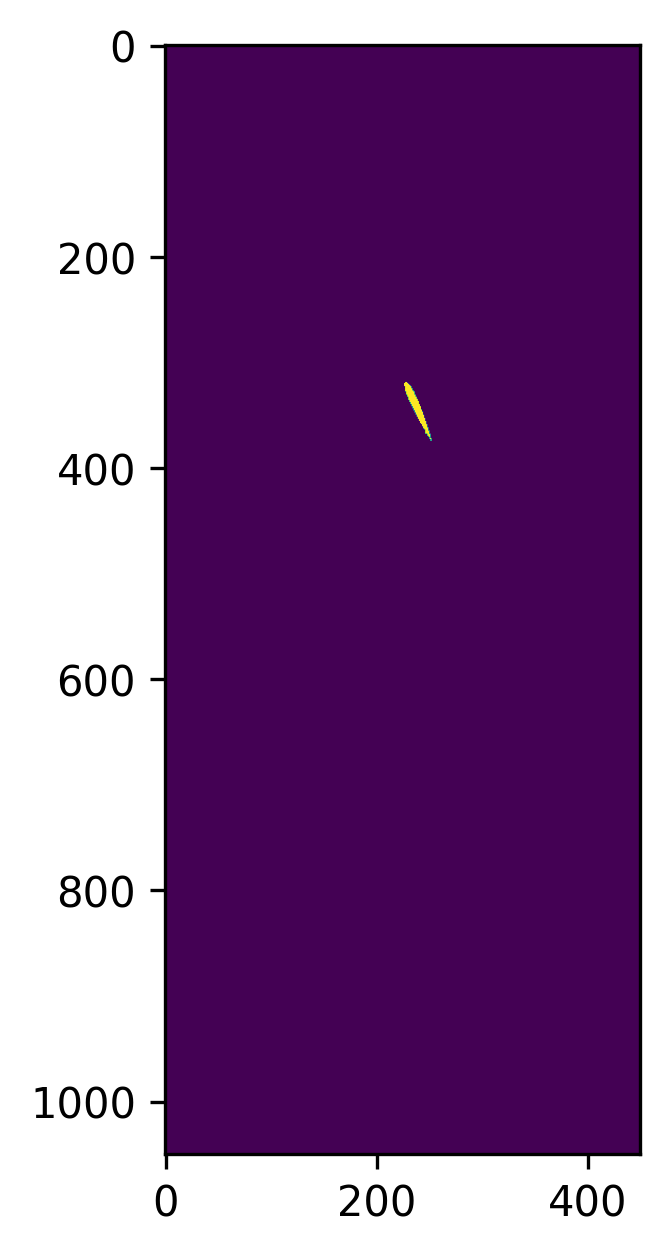

In [12]:
plt.imshow(get_profile_mask([cx_t,r_t,off_t]))

In [9]:
# The result is intersected with the original mask at the end of the next cell
# to get the actual boundary.
def chk_bdry_fluid(mask, i, j):
    # If True then the node is either solid or at the external boundary.
    for m in range(-1,2):
        for n in range(-1,2):
            if mask[i+m, j+n]:
                return True
                    
    return False

def get_extbdry_mask(obstacle):
    fluid_mask = np.logical_not(obstacle_mask)
    extbdry_mask = np.zeros((nx,ny), dtype=bool)
    for i in range(225,400):
        for j in range(175,275):
            extbdry_mask[i,j] = chk_bdry_fluid(obstacle_mask, i, j)
    
    extbdry_mask = extbdry_mask & fluid_mask
    return extbdry_mask

def get_links(obstacle, extbdry, v=v_lattice):
    extbdry_links = []
    for i in range(225,400):
        for j in range(175,275):
            if extbdry[i,j]:
                links = []
                for k in range(len(v)):
                    iv = v[k][0]
                    jv = v[k][1]
                    if obstacle[i+iv,j+jv]:
                        links.append(k)
                        
                extbdry_links.append([i, j, links])

    return extbdry_links
            

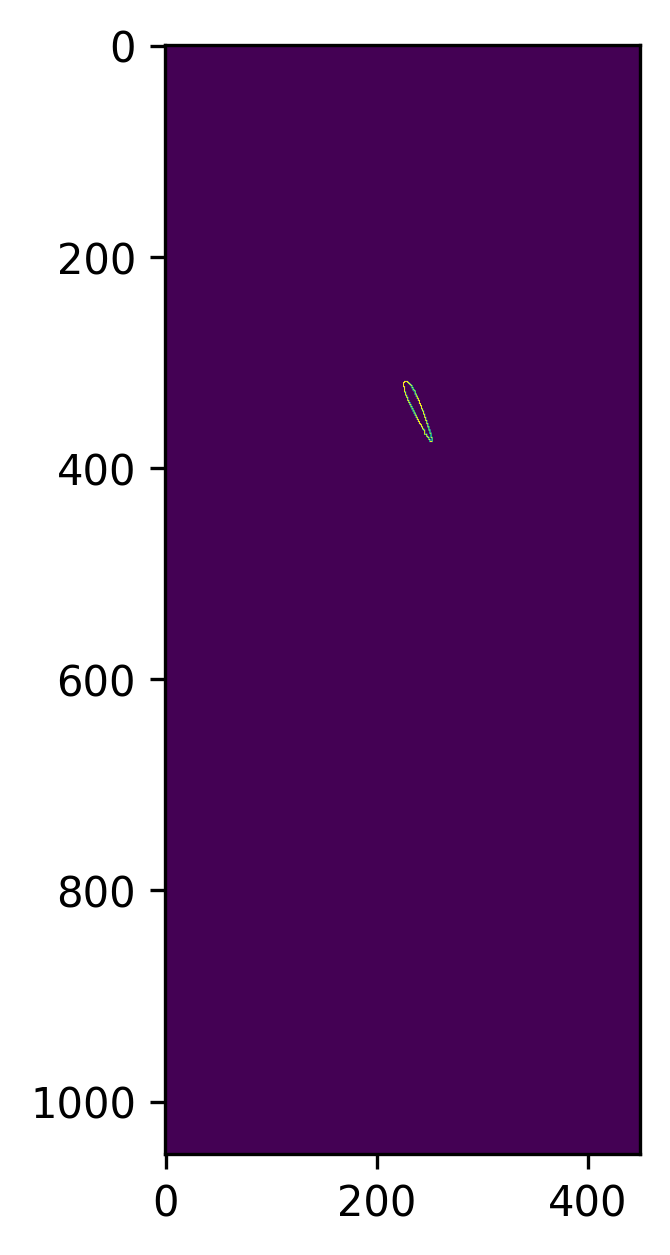

In [13]:
obstacle_mask = get_profile_mask([cx_t,r_t,off_t])
extbdry_mask = get_extbdry_mask(obstacle_mask)
plt.imshow(extbdry_mask)